In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
import pypsa
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from n_dimensional_datasets import *
from plotter import *

# approximation methods
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import LinearNDInterpolator

## user defines

In [82]:
start = 0
stop = 1
n_samples = 1000
train_percentage = 80
n_train_samples = int(n_samples*(train_percentage/100))

In [83]:
network = pypsa.Network()

network.set_snapshots(range(n_samples))

#add three buses
n_buses = 3
for i in range(n_buses):
    network.add("Bus","My bus {}".format(i), v_nom=20.)
    
# add radial lines
branches = 3
for i in range(0, int(n_buses/branches)):
    for j in range((i*branches)+1, (i*branches)+1+branches):
        if j < n_buses:
            network.add("Line",
                        "My line {}{}".format(i,j), 
                        bus0="My bus {}".format(i), 
                        bus1="My bus {}".format(j), 
                        x=0.01, r=0.1, s_nom=1)


#add a generator at bus 0
network.add("Generator","My gen 0", bus="My bus 0", p_nom=2, marginal_cost=1)
network.add("Generator","My gen 1", bus="My bus 1", p_nom=0.25, marginal_cost=1)

In [84]:
sim_data = {"start": start, "stop": stop, "samples": n_samples, "train samples": n_train_samples, "seed": []}
stats = {"score": [], "error": [], "scorevar": []}
approx_type = {"rf": copy.deepcopy(stats), "interp": copy.deepcopy(stats)}

seeds = range(1)
for seed in seeds:
    # create data
    X = stochastic_mesh(n_buses, start, stop, n_samples, seed=seed)
    X_train = X.T[:(n_train_samples)]
    X_test = X.T[(n_train_samples):]
    for i in range(n_buses):
        network.add("Load", "My load {}".format(i), bus="My bus {}".format(i), p_set=X[i])
    network.pf()
    y = network.buses_t.v_mag_pu.values
    y_train = y[:(n_train_samples)]
    y_test = y[(n_train_samples):]
    
    # setup approximators
    forest = RandomForestRegressor()
    forest.fit(X_train, y_train)
    
    interp = LinearNDInterpolator(X_train, y_train, fill_value=0)
    
    
    # score approximators
    forest_xval_score = cross_val_score(forest, X_train, y_train, cv=5)
    approx_type["rf"]["error"].append(np.mean(forest.predict(X_test)-y_test))
    approx_type["rf"]["score"].append(forest_xval_score.mean())
    approx_type["rf"]["scorevar"].append(forest_xval_score.std())
    
    interp_y_hat = interp(X_test)
    interp_score = r2_score(y_test, interp_y_hat)
    approx_type["interp"]["error"].append(np.mean(interp_y_hat - y_test))
    approx_type["interp"]["score"].append(interp_score)
    approx_type["interp"]["scorevar"].append(np.nan)
    
    sim_data["seed"].append(seed)
    
    print("Seed {} complete with an interpolation score {}".format(seed, interp_score))

for t in approx_type:
    print(t + " Stats: {}".format(pd.DataFrame(approx_type[t])))

Seed 0 complete with an interpolation score -11700827.184276948
rf Stats:       score     error  scorevar
0 -0.009191  0.000003  0.008959
interp Stats:           score     error  scorevar
0 -1.170083e+07 -0.094989       NaN


(200, 2) (200,) (200,)


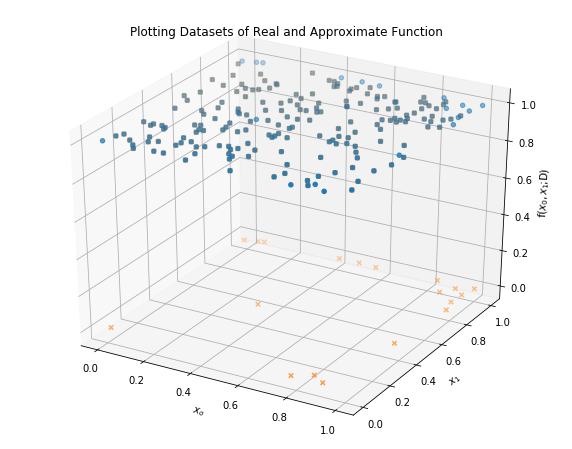

In [87]:
print(X_test.T[1:].T.shape, y_test.T[1].T.shape, interp(X_test).T[1].shape)
plot3d_approximation(X_test.T[1:], y_test.T[1], interp(X_test).T[1].T, save_filepath="badinterpolation.pdf")
plot3d_approximation(X_test.T[1:], y_test.T[1], forest.predict(X_test).T[1].T, save_filepath="badforest.pdf")